In [1]:
import tensorflow as tf
import os

In [2]:
#avoid OOM errors by setting GPU memory comsumption growth
#ensuring that not all the memory is used
gpus=tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [3]:
tf.config.list_physical_devices('GPU')

[]

remove doggy images


In [4]:
import cv2
import imghdr

C:\Users\Arushi\AppData\Local\Temp\ipykernel_32332\4232469594.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [10]:
data_dir='dataset_image_classification'

In [11]:
image_exts=['jpeg','jpg','bmp','png']

In [12]:
image_exts

['jpeg', 'jpg', 'bmp', 'png']

In [13]:
# plt.imshow(img)
# to chage from bgr to rgb
# plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [14]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

LOAD DATA

In [15]:
import numpy as np
from matplotlib import pyplot as plt

In [16]:
data = tf.keras.utils.image_dataset_from_directory(
    'dataset_image_classification'
)# make a data pipeline

Found 160 files belonging to 2 classes.


In [17]:
class_names = data.class_names
print(class_names)

['happy', 'sad']


In [18]:
data_iterator=data.as_numpy_iterator()
# easier access to data pipeline

In [19]:
batch=data_iterator.next()
# loop through data pipeline

In [20]:
# 0 for happy
# 1 for sad
batch[1]
#batch[0]==image as an array
#batch[1]==label of the image

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 1, 1, 0, 1, 0, 0], dtype=int32)

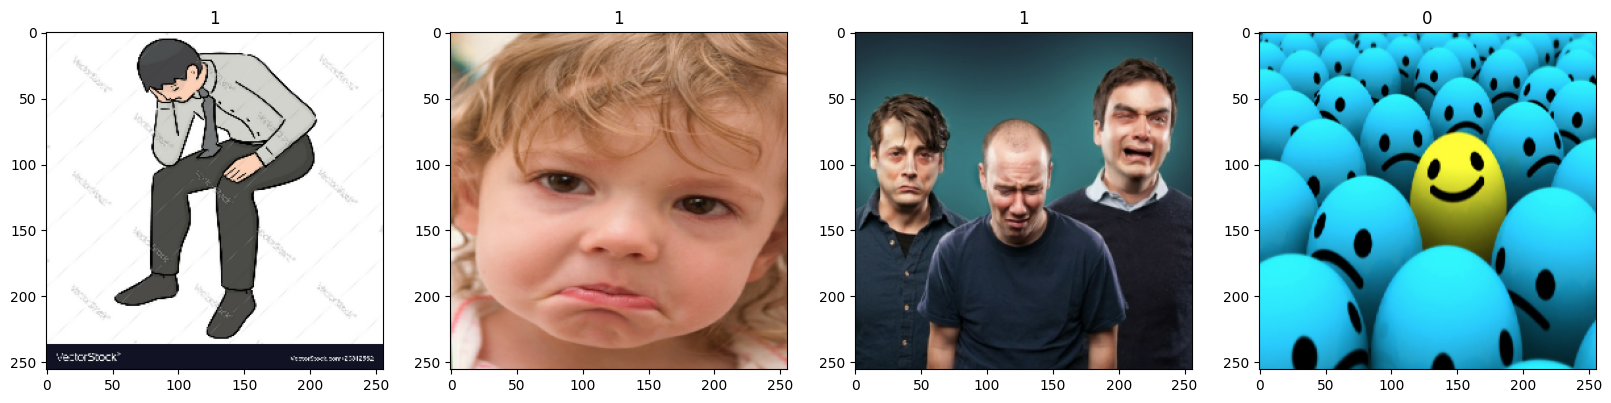

In [21]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

<h3>PREPROCESSING DATA</h3>
<hr>
<p>converting values of images between 0 and 1 instead of 0 to 255 (optimization)</p>
<p>and also splitting the data into training, testing and validation partiton to ensure that we dont overfit</p>

In [22]:
data=data.map(lambda x, y: (x/255, y))

In [23]:
scaled_it=data.as_numpy_iterator()

In [24]:
batch=scaled_it.next()

In [25]:
batch[0].min()

np.float32(0.0)

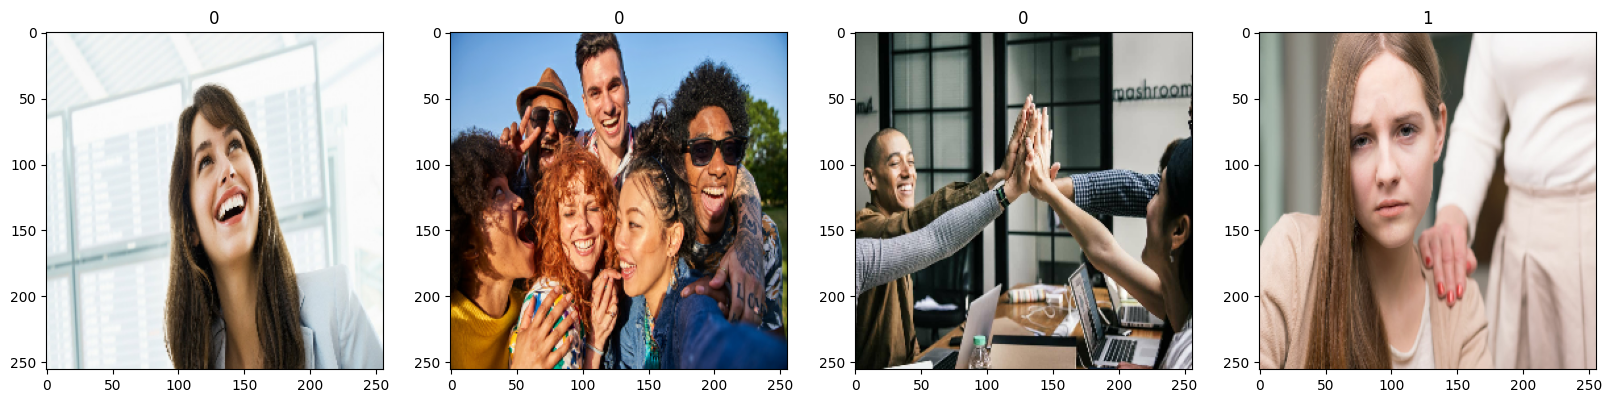

In [26]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

split data

In [27]:
train_size=int(len(data)*0.7)
val_size=int(len(data)*0.2)
test_size=int(len(data)*0.1)+1

In [28]:
train=data.take(train_size)
val=data.skip(train_size).take(val_size)
test=data.skip(train_size+val_size).take(test_size)

DEEP LEARNING MODEL <hr>
using keras sequential api

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [30]:
model=Sequential()

In [31]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

D:\python 3.11\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [32]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [33]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 14400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       3,686,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

train

In [34]:
logdir='log'

In [35]:
tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [36]:
hist=model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.5013 - loss: 1.2195 - val_accuracy: 0.4375 - val_loss: 0.8462
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.4544 - loss: 0.8137 - val_accuracy: 0.5312 - val_loss: 0.7189
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.5326 - loss: 0.7194 - val_accuracy: 0.8125 - val_loss: 0.6244
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.7083 - loss: 0.6459 - val_accuracy: 0.7812 - val_loss: 0.6523
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.8411 - loss: 0.6380 - val_accuracy: 0.8438 - val_loss: 0.6087
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.7747 - loss: 0.6155 - val_accuracy: 0.8438 - val_loss: 0.5106
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.7292 - loss: 0.5336 - val_accuracy: 0.6875 - val_loss: 0.5514
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 4s/step - accuracy: 0.7357 - loss: 0.4861 - val_accuracy: 0.8125 - val_loss: 0.4471
Epoch 9/20
3/

PLOT PERFORMANCE

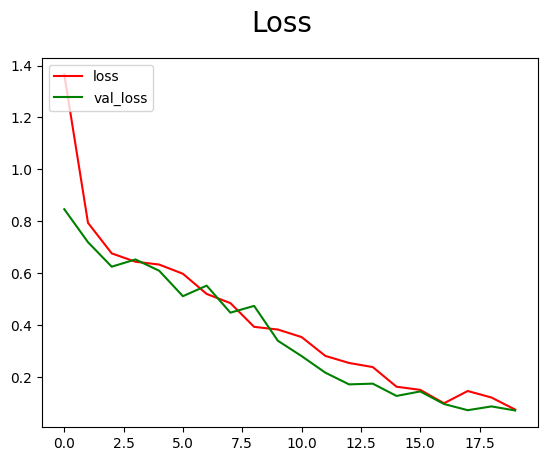

In [38]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='red', label='loss')
plt.plot(hist.history['val_loss'], color='green', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

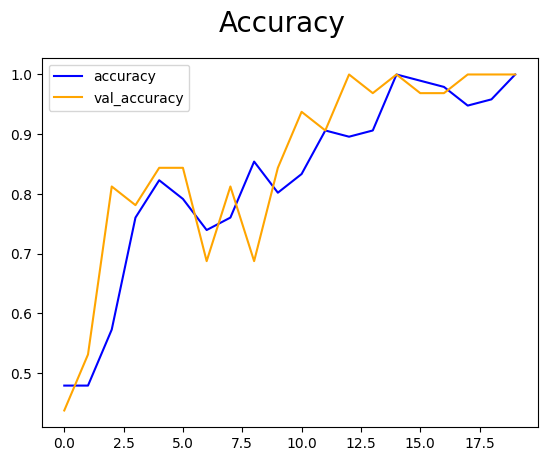

In [39]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='blue', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

EVALUATE
<hr>
precision, recall and accuracy

In [40]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [41]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [42]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


In [43]:
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision:1.0, Recall:1.0, Accuracy:1.0


TEST

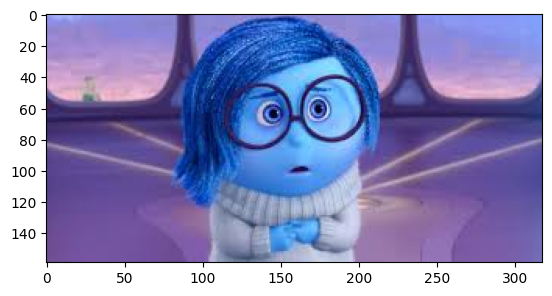

In [44]:
img = cv2.imread('test/sad_test1.jpeg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

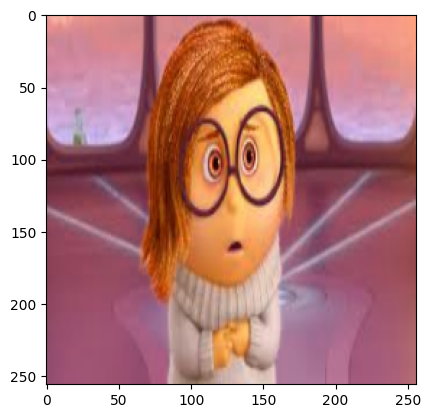

In [45]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [46]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


In [47]:
yhat

array([[0.76749045]], dtype=float32)

In [48]:
if yhat > 0.5:
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Sad


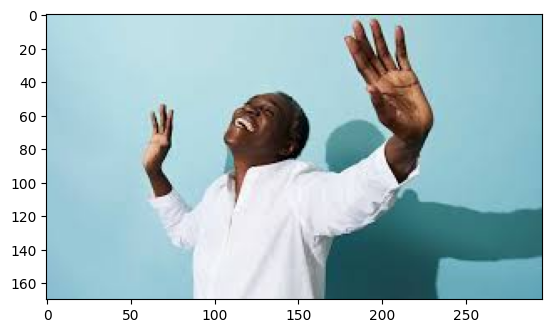

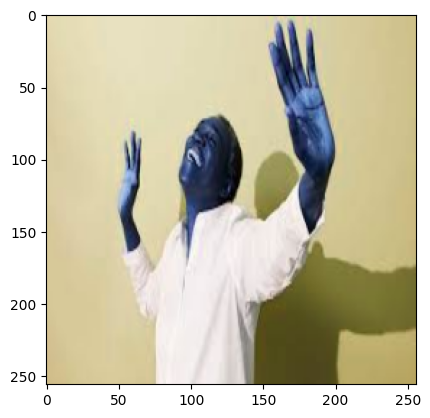

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
Predicted class is Happy


In [49]:
img = cv2.imread('test/happy_test1.jpeg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

yhat = model.predict(np.expand_dims(resize/255, 0))

yhat

if yhat > 0.5:
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

saving the model

In [50]:
from tensorflow.keras.models import load_model

In [51]:
model.save(os.path.join('models','happy_or_sad_.h5'))

In [52]:
new_model = load_model(os.path.join('models','happy_or_sad_.h5'))

In [53]:
yhat_new=new_model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


In [54]:
if yhat_new > 0.5:
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Happy
